# 02477 Exercise 3: Bayesian Linear regression

In [3]:
%matplotlib inline
import jax.numpy as jnp
from jax import value_and_grad
from jax import grad
from jax import random
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as snb
from scipy.stats import multivariate_normal

snb.set_theme(font_scale=1.25)

- Rev. 3.0, 22/11-24

### Overview

The purpose of this exercise is to become familiar with Bayesian linear regression and reinforce the basic concepts of Bayesian inference. 
In the exercise, you will implement several parts of Bayesian linear regression pipeline. However, remember that the purpose of the exercise is to study and understand the key equations for Bayesian linear regression as well as to learn how to use them. 
Besides being useful for practical purposes, the code also allows you to build intuition, e.g. by investigating what happens when you change different parameters etc. So think of the code as a tool for understanding the models and their key equations and not only as an end-product.

**Content**

- Part 1: Visualizing the prior, likelihood and posterior
- Part 2: Implementing the posterior distribution
- Part 3: The posterior predictive distribution
- Part 4: Modelling the number of Airline passengers





**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.



### Bayesian linear regression

Linear regression is perhaps the most common technique in applied statistics and machine learning for modelling the relationship between set of a covariates $\left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N$ and a response variable $\left\lbrace y_n \right\rbrace_{n=1}^N$. Rather than modelling the relationship between $\mathbf{x}_n$ and $y_n$ directly, we often apply a transformation $\phi$ to the input vectors $\mathbf{x}_n$ first. That is, we often use $\mathbf{\phi}_n = \mathbf{\phi}(\mathbf{x}_n)$ as input to regression model rather than $\mathbf{x}_n$ directly:

\begin{align*}
y_n = f(\mathbf{x}_n) + e_n = \phi(\mathbf{x}_n)^T \mathbf{w} + e_n = \mathbf{\phi}_n^T \mathbf{w} + e_n,
\end{align*}

where $f(\mathbf{x_n}) \equiv \mathbf{\phi}_n^T \mathbf{w}$.


More generally, let $\mathbf{\Phi} \in \mathbb{R}^{N \times D}$ be a **design matrix** and let  $\mathbf{y} \in \mathbb{R}^N$ be the response variables, then the linear regression model is given by

\begin{align*}
\mathbf{y}= \mathbf{\Phi}\mathbf{w} + \mathbf{e},
\end{align*}


where $\mathbf{w} \in \mathbb{R}^D$ is the regression weights and $\mathbf{e} \in \mathbb{R}^N$ is a noise vector. In this exercise, we will only look at additive isotropic Gaussian noise models, i.e. $e_n \sim \mathcal{N}(0, \sigma^2)$, but later we will study more general set-ups. Recall, the **maximum likelihood estimator** of the weights $\mathbf{w}$ is given by

\begin{align*}
\hat{\mathbf{w}}_{\text{MLE}} = \left(\mathbf{\Phi}^T \mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^T \mathbf{y}
\end{align*}

We will now turn to the Bayesian treatment. Assuming isotropic Gaussian noise and imposing a multivariate Gaussian prior on $\mathbf{w} \sim \mathcal{N}\left(\mathbf{m}_0, \mathbf{S}_0\right)$ gives rise to the following joint distribution

\begin{align*}
p(\mathbf{y}, \mathbf{w}) = p\left(\mathbf{y}|\mathbf{w}\right)p\left(\mathbf{w}\right) = \mathcal{N}\left(\mathbf{y}\big|\mathbf{\Phi}\mathbf{w}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{w}\big|\mathbf{m}_0, \mathbf{S}_0\right),
\end{align*}

where $\sigma^2$ is the noise variance. We will follow Bishop's notation and use the **noise precision** $\beta = \frac{1}{\sigma^2}$ to parametrize the noise variance.

#### The posterior distribution 

In contrast to the model we worked with last week, this model is an example of a **conjugate** model, meaning that the posterior distribution will also be a Gaussian distribution given by:

\begin{align*}
p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S})
\end{align*}

where the posterior covariance is given by
\begin{align*}
    \mathbf{S} &= \left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\tag{1}
\end{align*}
and the posterior mean
\begin{align*}
\mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{y}.  \tag{2}
\end{align*}



The **posterior distribution** $p(\mathbf{w}|\mathbf{y})$ quantifies our knowledge of the parameter after having observed the data $\mathbf{y}$. Hence, we can use the posterior distribution to reason about the size of the coefficients in the linear model. For example, we can use the posterior mean as an estimator of the coefficients and the posterior variance to quantify the uncertainty. 

#### The posterior predictive distribution

The posterior distribution also plays a crucial role when computing the **posterior predictive distribution**

$$\begin{align*}
p(y^*|\mathbf{y}, \mathbf{x}^*) &= \int p(y^*|\mathbf{x}^*, \mathbf{w})p(\mathbf{w}|\mathbf{y})\text{d}\mathbf{w} = \int \mathcal{N}(y^*|\phi^T_n \mathbf{w}, \beta^{-1}) \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S}) \text{d}\mathbf{w}
= \mathcal{N}(y_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_* + \beta^{-1}),
\end{align*}
$$

which we will dive deeper into later in the exercise.



First, we will look at the following a simple model:
\begin{align*}
y_n = a + bx_n +  e_n = \begin{bmatrix}1&x_n\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} + e_n = \mathbf{\phi}_n^T \mathbf{w} + e_n.
\end{align*}

That is, $\mathbf{w} = \begin{bmatrix}a \\ b \end{bmatrix}$, where $a$ and $b$ are the intercept and slope of the line, respectively, and $\phi(x_n) = \begin{bmatrix}1 \\ x_n \end{bmatrix}$. Furthermore, we will assume a zero-mean and isotropic Gaussian prior, i.e. $\mathbf{m}_0 = \mathbf{0}$, $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$,



### Part 1:  Visualizing the prior, likelihood and posterior

First, we will work with the following toy dataset with $N = 20$ data points:

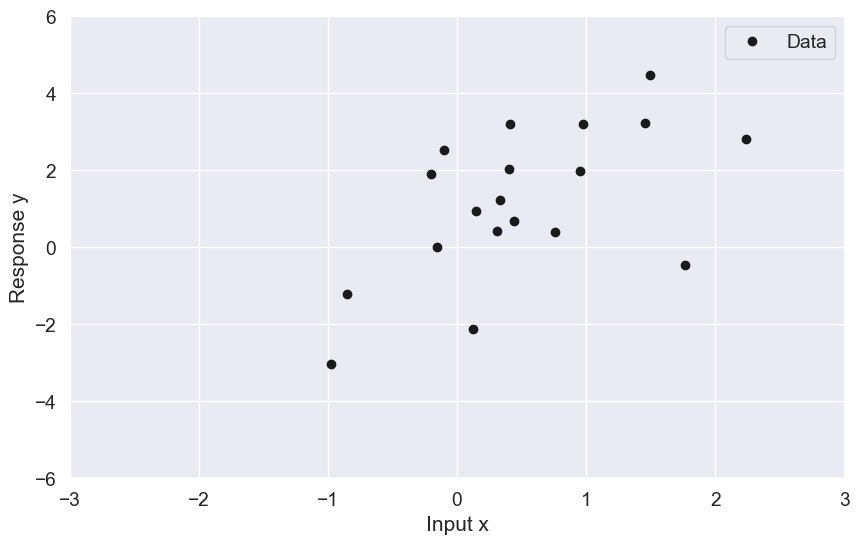

In [4]:
N = 20

xtrain = jnp.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151, -0.103, 0.411, 0.144, 1.454, 0.761, 0.122,
              0.444, 0.334, 1.494, -0.205,  0.313, -0.854])[:, None]
ytrain = jnp.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009, 2.513, 3.194, 0.935, 3.216, 0.386, -2.118,
               0.674, 1.222, 4.481, 1.893, 0.422,  -1.209])[:, None]

# plot
def plot_toydata(ax):
    ax.plot(xtrain, ytrain, 'k.', label='Data', markersize=12)
    ax.set(xlabel='Input x', ylabel='Response y', xlim=(-3, 3), ylim=(-6, 6))
    ax.legend()

fig, ax = plt.subplots(1,1, figsize=(10, 6))
plot_toydata(ax)

The purpose of this part is to understand the basic building blocks of the linear model and reinforce the concepts of prior, likelihood, and posterior. First, we will define a convenient function for evaluating and plotting distributions using densities.

In [5]:
def plot_distribution(ax, x, y, density_fun, color=None, visibility=1, label=None, title=None, num_points = 100):
    
    # create grid for parameters (a,b)
    a_array = jnp.linspace(-4, 4, num_points)
    b_array = jnp.linspace(-4, 4, num_points)
    A_array, B_array = jnp.meshgrid(a_array, b_array)   
    
    # form array with all combinations of (a,b) in our grid
    AB = jnp.column_stack((A_array.ravel(), B_array.ravel()))
    
    # evaluate density for every point in the grid and reshape bac
    Z = density_fun(x, y, A_array.ravel(), B_array.ravel())
    Z = Z.reshape((len(a_array), len(b_array)))
    
    # plot contour  
    ax.contour(a_array, b_array, jnp.exp(Z), colors=color, alpha=visibility)
    ax.plot([-1000], [-1000], color=color, label=label)
    ax.set(xlabel='slope', ylabel='intercept', xlim=(-4, 4), ylim=(-4, 4), title=title)

Then we will implement the prior, likelihood and posterior densities:

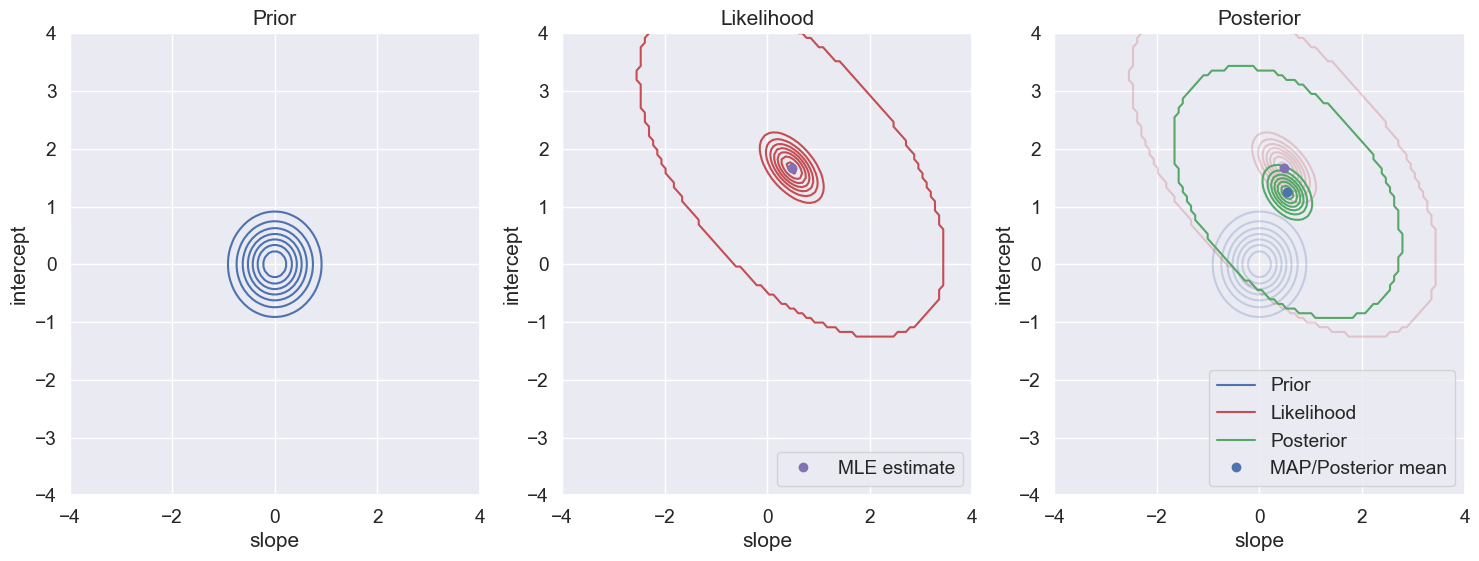

In [6]:
# hyperparameters
alpha = 5
beta = 3/4

# log normal probability density function
log_npdf = lambda x, m, v: -0.5*jnp.log(2*jnp.pi*v) -0.5*(x-m)**2/v 

# simple function for making predictions
predict = lambda x, a, b: a + b*x

def log_prior(x, y, a, b):
    return multivariate_normal.logpdf(jnp.column_stack([a, b]), jnp.array([0, 0]), 1/alpha*jnp.identity(2))

def log_likelihood(x, y, a, b):
    return jnp.sum(log_npdf(y, predict(x, a, b), 1/beta), 0)

def log_posterior(x, y, a, b):
    return log_prior(x, y, a, b) + log_likelihood(x, y, a, b)

def design_matrix(x):
    return jnp.column_stack((jnp.ones(len(x)), x))

# plot
fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_distribution(axes[0], xtrain, ytrain, density_fun=log_prior, color='b', title='Prior')
plot_distribution(axes[1], xtrain, ytrain, density_fun=log_likelihood, color='r', title='Likelihood')
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_prior, color='b', visibility=0.25, label='Prior')
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_likelihood, color='r', visibility=0.25, label='Likelihood')
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_posterior, color='g', label='Posterior', title='Posterior')

##################################################################
# Insert your solution here
##################################################################

Phi_train = design_matrix(xtrain)

# compute maximum likelihood estimator for w
w_MLE = jnp.linalg.solve(Phi_train.T@Phi_train, Phi_train.T@ytrain).ravel()

# compute MAP/posterior mean
w_MAP = (beta*jnp.linalg.solve(alpha*jnp.identity(2) + beta*(Phi_train.T@Phi_train), Phi_train.T)@ytrain).ravel()

# plot
axes[1].plot(w_MLE[0], w_MLE[1], 'mo', label='MLE estimate')
axes[2].plot(w_MLE[0], w_MLE[1], 'mo')
axes[2].plot(w_MAP[0], w_MAP[1], 'bo', label='MAP/Posterior mean')

##################################################################
# end of solution
##################################################################

axes[1].legend(loc='lower right');
axes[2].legend(loc='lower right');


**Task 1.1**: Compute the maximum likelihood solution (MLE), the MAP solution and the posterior mean for the slope and intercept. Plot all three points in the right-most panel above.

**Task 1.2**: Explain the role of $\alpha$ and $\beta$ based on the plots above. What happens if you increase or decrease $\alpha$ or $\beta$?  [**Discussion question**]



$\alpha$  controls the strength of the prior  $p(w)$ , which is Gaussian  $\mathcal{N}(0, \frac{1}{\alpha} I)$. A smaller $\alpha$  means a weaker prior, allowing the likelihood to influence the posterior more.

$\beta$  controls the noise variance  $\sigma^2 = 1/\beta$  in the likelihood  $p(y | x, w)$ . A larger  $\beta$  means lower noise, leading to a more confident posterior.

**Task 1.3**: What happens to the posterior mean and covariance if you let $\beta$ approach zero (this is equivalent to the noise variance going to infinity)? Explain what you see using eq. (1) and (2) above.

**Solution**

From eq. (1) above, we see that the posterior covariance reverts to the prior covariance when $\beta \rightarrow 0$
\begin{align*}
    \lim\limits_{\beta \rightarrow 0}\mathbf{S} =  \lim\limits_{\beta\rightarrow 0}\left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1} =  \left(\mathbf{S}_0^{-1} \right)^{-1} = \mathbf{S}_0
\end{align*}
Similarly, for the posterior mean
\begin{align*}
    \mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{y} = \beta \left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y} = \left(\beta^{-1}\mathbf{S}_0^{-1} + \beta^{-1}\beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y} = \left(\beta^{-1}\mathbf{S}_0^{-1} + \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}
\end{align*}

When $\beta$ approach 0, $\beta$ increases and eventually the term for the prior covariance ($\beta^{-1} \mathbf{S}_0^{-1}$) will dominate the sum in the inverse yielding
\begin{align*}
    \mathbf{m} \approx \left(\beta^{-1}\mathbf{S}_0^{-1}\right)^{-1}\mathbf{\Phi}^T\mathbf{y} = \beta\mathbf{S}_0\mathbf{\Phi}^T\mathbf{y} \rightarrow 0
\end{align*}
Therefore, $\mathbf{m}$ converges to the zero vector, which is the prior mean, as $\beta \rightarrow 0$. Since $\beta$ controls the precision of our observations, it makes intuitive sense that the model become independent of the data when the precision goes to zero (or equivalently, when the noise variance goes to infinity).

**End of solution**




**Task 1.4** Show that when we make the prior distribution infinitely wide, i.e. $\alpha \rightarrow 0$, then the posterior mean converges to the maximum likelihood solution.


*Hints*: 
- Recall: $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$
- Substitute the expression for the posterior covariance in eq. (1) into the expression for the posterior mean in eq. (2) and take the limit $\alpha \rightarrow 0$.

**Solution**

Substituting eq. (1) into eq. (2) yields
\begin{align*}
    \mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{y} = \beta\left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}
\end{align*}

Next, let's substitute $\mathbf{S}_0 = \alpha^{-1} \mathbf{I}$ into the equation above to get
\begin{align*}
    \mathbf{m} = \beta\left(\alpha \mathbf{I} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}
\end{align*}

Taking the limit $\alpha \rightarrow 0$ yields
\begin{align*}
    \lim\limits_{\alpha \rightarrow 0} \mathbf{m} &= \beta\left(\beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}\\
    %
    &= \beta\beta^{-1}\left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}\\
    %
    &= \left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}\\
    %
    &= \hat{\mathbf{w}}_{\text{MLE}}
\end{align*}

and the result follows.

**End of solution**


## Part 2:  Implementing the posterior distribution

In the cell below, you are given an incomplete implementation of Bayesian linear regression. Your task is to complete the implementation. See details below.

In [7]:
class BayesianLinearRegression(object):
    
    def __init__(self, Phi, y, alpha=1., beta=1.):
        
        # store data and hyperparameters
        self.Phi, self.y = Phi, y
        self.N, self.D = Phi.shape
        self.alpha, self.beta = alpha, beta
        
        # compute posterior distribution
        self.m, self.S = self.compute_posterior(alpha, beta)
        self.log_marginal_likelihood = self.compute_marginal_likelihood(alpha, beta)

        # perform sanity check of shapes/dimensions
        self.check_dimensions()

    def check_dimensions(self):
        D = self.D
        assert self.y.shape == (self.N, 1), f"Wrong shape for data vector y.\n For N = {N}, the shape of y must be ({N}, 1), but the actual shape is {self.y.shape}"
        assert self.m.shape == (D, 1), f"Wrong shape for posterior mean.\nFor D = {D}, the shape of the posterior mean must be ({D}, 1), but the actual shape is {self.m.shape}"
        assert self.S.shape == (D, D), f"Wrong shape for posterior covariance.\nFor D = {D}, the shape of the posterior mean must be ({D}, {D}), , but the actual shape is {self.S.shape}"

    def compute_posterior(self, alpha, beta):
        """ computes the posterior N(w|m, S) and return m, S.
            Shape of m and S must be (D, 1) and (D, D), respectively  """
        
        #############################################
        # Insert your solution here
        #############################################
        
        # compute prior and posterior precision 
        inv_S0 = alpha*jnp.identity(self.D)
        A = inv_S0 + beta*(self.Phi.T@self.Phi)
        
        # compute mean and covariance 
        m = beta*jnp.linalg.solve(A, self.Phi.T)@self.y   # eq. (2) above
        S = jnp.linalg.inv(A)                             # eq. (1) above
        
        #############################################
        # End of solution
        #############################################
        return m, S
      
    def generate_prior_samples(self, key, num_samples):
        """ generate samples from the prior  """
        return random.multivariate_normal(key, jnp.zeros(len(self.m)), (1/self.alpha)*jnp.identity(len(self.m)), shape=(num_samples, ))
    
    def generate_posterior_samples(self, key, num_samples):
        """ generate samples from the posterior  """
        return random.multivariate_normal(key, self.m.ravel(), self.S, shape=(num_samples, ))
    
    def predict_f(self, Phi):
        """ computes posterior mean (mu_f) and variance (var_f) of f(phi(x)) for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_f and var_f must be (N,)
            The function returns (mu_f, var_f)
        """
        mu_f = (Phi@self.m).ravel()   
        var_f = jnp.diag(Phi@self.S@Phi.T)   
        
        # check dimensions before returning values
        assert mu_f.shape == (Phi.shape[0],), "Shape of mu_f seems wrong. Check your implementation"
        assert var_f.shape == (Phi.shape[0],), "Shape of var_f seems wrong. Check your implementation"
        return mu_f, var_f
        
    def predict_y(self, Phi):
        """ returns posterior predictive mean (mu_y) and variance (var_y) of y = f(phi(x)) + e for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_y and var_y must be (N,).
            The function returns (mu_y, var_y)
        """
        mu_f, var_f = self.predict_f(Phi)
        mu_y = mu_f                  
        var_y = var_f + 1/self.beta  

        # check dimensions before returning values
        assert mu_y.shape == (Phi.shape[0],), "Shape of mu_y seems wrong. Check your implementation"
        assert var_y.shape == (Phi.shape[0],), "Shape of var_y seems wrong. Check your implementation"
        return mu_y, var_y
        
    
    def compute_marginal_likelihood(self, alpha, beta):
        """ computes and returns log marginal likelihood p(y|alpha, beta) """
        inv_S0 = alpha*jnp.identity(self.D)
        A = inv_S0 + beta*(self.Phi.T@self.Phi)
        m = beta*jnp.linalg.solve(A, self.Phi.T)@self.y   # (eq. 3.53 in Bishop)
        S = jnp.linalg.inv(A)                             # (eq. 3.54 in Bishop)
        Em = beta/2*jnp.sum((self.y - self.Phi@m)**2) + alpha/2*jnp.sum(m**2)
        return self.D/2*jnp.log(alpha) + self.N/2*jnp.log(beta) - Em - 0.5*jnp.linalg.slogdet(A)[1] - self.N/2*jnp.log(2*jnp.pi)
         

    def optimize_hyperparameters(self):
        # optimizes hyperparameters using marginal likelihood
        theta0 = jnp.array((jnp.log(self.alpha), jnp.log(self.beta)))
        def negative_marginal_likelihood(theta):
            alpha, beta = jnp.exp(theta[0]), jnp.exp(theta[1])
            return -self.compute_marginal_likelihood(alpha, beta)

        result = minimize(value_and_grad(negative_marginal_likelihood), theta0, jac=True)

        # store new hyperparameters and recompute posterior
        theta_opt = result.x
        self.alpha, self.beta = jnp.exp(theta_opt[0]), jnp.exp(theta_opt[1])
        self.m, self.S = self.compute_posterior(self.alpha, self.beta)
        self.log_marginal_likelihood = self.compute_marginal_likelihood(self.alpha, self.beta)

# sanity check of implementation
model = BayesianLinearRegression(0.5*jnp.ones((2,2)), 2*jnp.ones((2, 1)), alpha=0.5, beta=0.5)       
assert jnp.allclose(model.m, jnp.array([1, 1])), "Something seems to be wrong with your implementation of the posterior mean. Please check your implementation." 
assert jnp.allclose(model.S, jnp.array([[1.5, -0.5], [-0.5, 1.5]])), "Something seems to be wrong with your implementation of the posterior covariance. Please check your implementation." 

# fit model to toy dataset
Phi_train = design_matrix(xtrain)
model = BayesianLinearRegression(Phi_train, ytrain)


**Task 2.1**: Complete the implementation of the function *compute_posterior* above using eq. (1) and (2).




**Task 2.2**: Report the posterior mean and a 95\% credibility interval for the intercept and slope for $\alpha=\beta=1$. Compare your estimate to the plot of the data above. Do the results look reasonable compared to the plots above?

*Hint: There are several ways to approach this. E.g. for a Gaussian random variable $\mathcal{N}(\mu, \sigma^2)$, the interval $\left[\mu - 1.96\sigma, \mu + 1.96\sigma\right]$ contains approximately 95\% of its probability mass.*


In [8]:
##############################################
# Your solution goes here
##############################################

diag_S = jnp.diag(model.S)
lower = model.m.ravel() - 1.96*jnp.sqrt(diag_S)
upper = model.m.ravel() + 1.96*jnp.sqrt(diag_S)

for i, name in zip(range(2), ['Intercept', 'Slope']): 
    print(f'{name}')
    print(f'\tPost. Mean\t: {model.m[i,0]:3.2f}')
    print(f'\t95%-Interval\t: [{lower[i]:3.2f}-{upper[i]:3.2f}]')

##############################################
# End of solution
##############################################

Intercept
	Post. Mean	: 0.51
	95%-Interval	: [0.00-1.01]
Slope
	Post. Mean	: 1.58
	95%-Interval	: [1.09-2.08]


### Part 3:  The posterior predictive distribution

Next, we will use our toy dataset from above to study the relationship between the posterior distribution $p(\mathbf{w}|\mathbf{y})$ and the posterior predictive distribution $p(y^*|\mathbf{x}^*, \mathbf{y})$.
After we obtained the posterior distribution $p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}| \mathbf{m}, \mathbf{S})$, we can also compute the distributions of $f_* = f(\mathbf{x}_*) = \phi(x_*)^T \mathbf{w}$ and $y_* = f(\mathbf{x}_*, \mathbf{w}) + e$ for any new data point $\mathbf{x}_*$:

$$\begin{align*}
p(f_*|\mathbf{y}, \mathbf{x}_*) &=  \mathcal{N}(f_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_*)\\
p(y_*|\mathbf{y}, \mathbf{x}_*) &=  \mathcal{N}(y_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_* + \beta^{-1}).
\end{align*}$$

We often refer to the former as the **posterior distribution of $f_*$** and to latter as the **posterior predictive distribution for $y_*$**. Before studying the relationship, let's implement the two distributions.



**Task 3.1**: Go back up to the implementation of the class *BayesianLinearRegression* and complete the implementation of the functions *predict_f* and *predict_y*. These functions compute and return the mean and variance of $p(f_*|\mathbf{x}_*, \mathbf{y})$ and $p(y_*|\mathbf{x}_*, \mathbf{y})$, respectively, for a design matrix of new input points.

*Hints: The cell below will do a simple sanity check of your implementation. Passing the sanity check does not guarantee that your implementation is correct, though*


In [9]:
# sanity check to help verify implementation
dummy_model = BayesianLinearRegression(jnp.ones((2,2)), jnp.ones((2, 1)), 1, 1)
dummy_mu_f, dummy_var_f = dummy_model.predict_f(jnp.ones((1,2)))
dummy_mu_y, dummy_var_y = dummy_model.predict_y(jnp.ones((1,2)))

assert jnp.allclose(dummy_mu_f, jnp.array([0.8])), "Posterior mean of f_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_var_f, jnp.array([0.4])), "Posterior variance of f_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_mu_y, jnp.array([0.8])), "Posterior predictive mean of y_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_var_y, jnp.array([1.4])), "Posterior predictive variance of y_* seems wrong. Please check your implementation"

Assuming your implementation above is correct, the cell below analyses the data set using $N = \left\lbrace 0, 1, 2, 5, 10, 20 \right\rbrace$, respectively, where the first row shows the results for $N = 0$ and so on and so forth. 


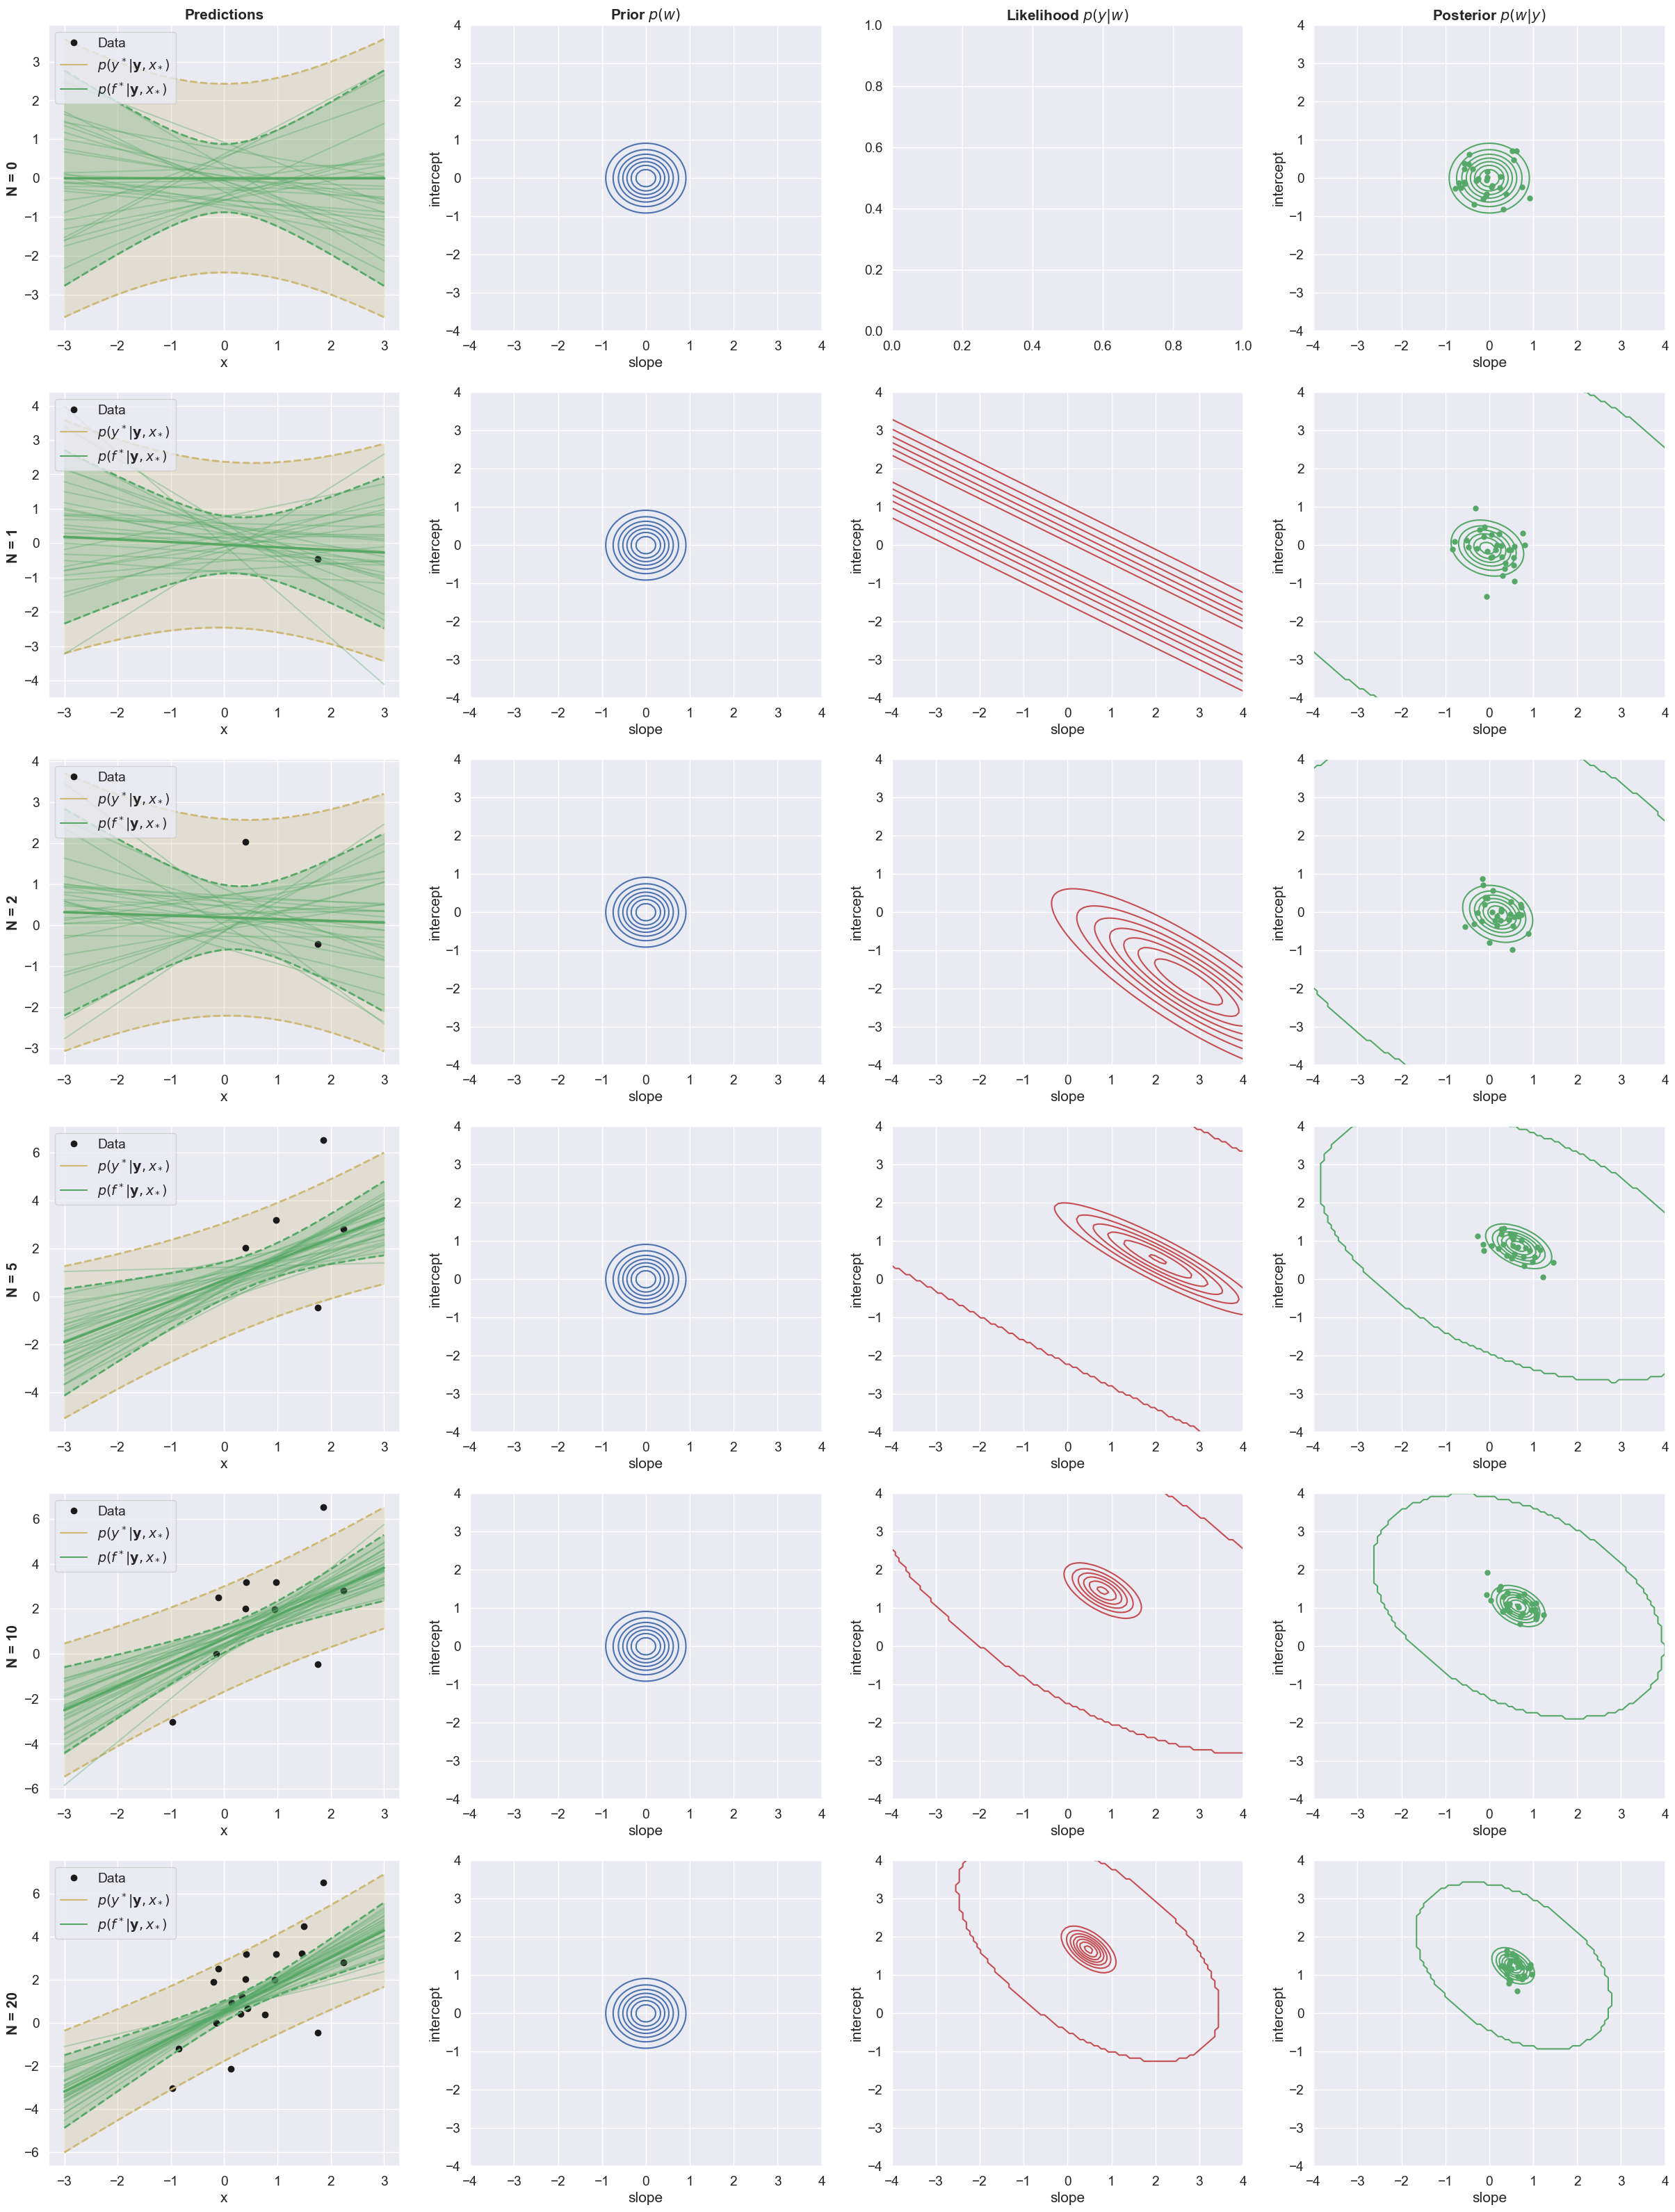

In [10]:
# helper function for visualizing predictions
def plot_predictions(ax, x, mu, var, color='r', visibility=0.5, label=None):
    lower, upper = mu - 1.96*jnp.sqrt(var), mu + 1.96*jnp.sqrt(var)
    ax.plot(x, mu, color=color, label=label)
    ax.plot(x, lower, color=color, linewidth=2, linestyle='--')
    ax.plot(x, upper, color=color, linewidth=2, linestyle='--')
    ax.fill_between(x.ravel(), lower.ravel(), upper.ravel(), color=color, alpha=visibility)
    ax.plot(x, mu, '-', color=color, label="", linewidth=2.5)
    
# fix seed
seed = 123
key = random.PRNGKey(seed)

# fix hyperparameters
alpha = 5
beta = 3/4

# num posterior samples to plot
num_samples = 30

# design matrices
xpred = jnp.linspace(-3, 3, 50)[:, None]
Phi_train = design_matrix(xtrain)
Phi_pred = design_matrix(xpred)

fig, axes = plt.subplots(6, 4, figsize=(30, 40))    
for idx_n, n in enumerate([0, 1, 2, 5, 10, 20]):

    key, sample_key = random.split(key)
    
    # compute posterior of regression weights 
    model = BayesianLinearRegression(Phi_train[:n, :], ytrain[:n, :], alpha, beta)
    w_samples = model.generate_posterior_samples(sample_key, num_samples=num_samples)
    
    # split samples in a and b computes
    a_samples, b_samples = w_samples[:, 0], w_samples[:, 1]
    
    # computer posterior function values for f and y
    mu_f, var_f = model.predict_f(Phi_pred)
    mu_y, var_y = model.predict_y(Phi_pred)
    
    # plot in data space
    axes[idx_n, 0].plot(xtrain[:n, :], ytrain[:n, :], 'k.', markersize=12, label='Data')
    plot_predictions(axes[idx_n, 0], xpred, mu_y, var_y, visibility=0.25, color='y', label='$p(y^*|\\mathbf{y}, x_*)$')
    plot_predictions(axes[idx_n, 0], xpred, mu_f, var_f, visibility=0.25, color='g', label='$p(f^*|\\mathbf{y}, x_*)$')
    axes[idx_n, 0].set_ylabel('N = %d' % n, fontweight='bold')    
    for i, (ai, bi) in enumerate(zip(a_samples, b_samples)):
        axes[idx_n, 0].plot(xpred, predict(xpred, ai, bi), 'g-', alpha=0.35)
        
    axes[idx_n, 0].legend(loc='upper left')
    axes[idx_n, 0].set(xlabel='x')
    
    # plot prior
    plot_distribution(axes[idx_n, 1], xtrain[:n, :], ytrain[:n, :], density_fun=log_prior, color='b')
    
    # plot likelihood
    if n > 0:
        plot_distribution(axes[idx_n, 2], xtrain[:n, :], ytrain[:n, :], density_fun=log_likelihood, color='r')
        
    # plot posterior
    plot_distribution(axes[idx_n, 3], xtrain[:n, :], ytrain[:n, :], density_fun=log_posterior, color='g')
    axes[idx_n, 3].plot(a_samples, b_samples, 'g.', markersize=10)
        
    
axes[0, 0].set_title('Predictions', fontweight='bold');
axes[0, 1].set_title('Prior $p(w)$', fontweight='bold');
axes[0, 2].set_title('Likelihood $p(y|w)$', fontweight='bold');
axes[0, 3].set_title('Posterior $p(w|y)$', fontweight='bold');

In the figure above, the first column shows the data as well as the predictive distribution with 95% intervals. Each of the green lines corresponds to the function $f(x)$ for different posterior samples for $\mathbf{w}$. The columns 2, 3, and 4 show the prior, likelihood and posterior, respectively. Study the code and the plots above and answer the following questions:

**Task 3.2**: What happens to prior, likelihood and posterior as the number of samples $N$ increases? [**Discussion question**]



**Task 3.3**: What happens to the predictions if you keep $\beta = \frac{3}{4}$ and increase $\alpha$, e.g. to $\alpha = 100$ or $\alpha = 1000$? Why? [**Discussion question**]



**Task 3.4**: Set $\alpha$ to $\alpha = 1$ again. What happens if you decrease $\beta$, e.g. to $\beta = 0.1$? Why? [**Discussion question**]


**Task 3.5**: The variance of the predictive distribution $p(y_*|\mathbf{y}, \mathbf{x}_*)$ contains two components. Describe the two components in your own words and relate them to epistemic and aleatoric uncertainty. [**Discussion question**]


**Task 3.6**: As we get more and more data, the variance of the posterior distribution of $\mathbf{w}$ goes to zero. What happens to the variance of $p(y_*|\mathbf{y}, \mathbf{x}_*)$, $p(y^*|\mathbf{x}^*, \mathbf{w})$, and $p(f_*|\mathbf{y}, \mathbf{x}_*)$ as $N$ increases? To answer this, fix $\alpha = \beta = 1$ and consider the point $x^* = 1$. Plot the following three variances: the posterior predictive variance of $y^*$, the conditional variance of $y^*$ given $\mathbf{w}$ and posterior variance of $f^*$ as a function as size of the training set, i.e. for $N = \left\lbrace 0, 1, 2, .., 30 \right\rbrace$. Compare the plots to your findings above.

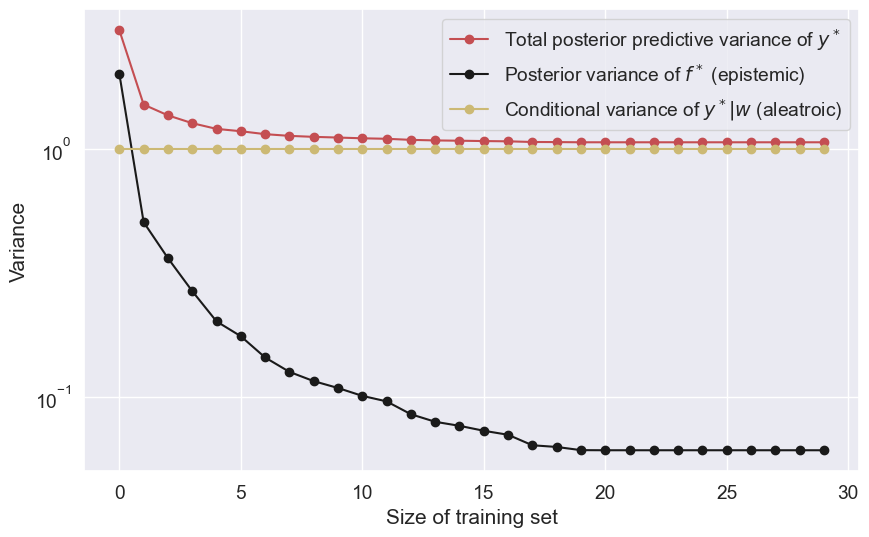

In [11]:
alpha, beta = 1, 1
xstar = 1
Ns = jnp.arange(30)

#########################################################
# Insert your solution here
#########################################################

post_pred_var = []
conditional_var = []
post_var = []
for idx_n, n in enumerate(Ns):
    
    # compute posterior of regression weights 
    model = BayesianLinearRegression(Phi_train[:n, :], ytrain[:n, :], alpha, beta)

    # computer posterior function values for f and y
    mu_f, var_f = model.predict_f(design_matrix(jnp.array([xstar])))
    mu_y, var_y = model.predict_y(design_matrix(jnp.array([xstar])))

    # save
    post_pred_var.append(var_y)
    conditional_var.append(1/beta)
    post_var.append(var_f)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10 ,6))
ax.plot(Ns, post_pred_var, 'ro-', label='Total posterior predictive variance of $y^*$')
ax.plot(Ns, post_var, 'ko-', label='Posterior variance of $f^*$ (epistemic)')
ax.plot(Ns, conditional_var, 'yo-', label='Conditional variance of $y^*|w$ (aleatroic)')
ax.set(ylabel='Variance',xlabel='Size of training set')
ax.set_yscale('log')
ax.legend()

#################################################3
# End of solution
#################################################3


**Task 3.7**: Compute the prior mean and variance $f(x^*) = \phi(x^*)^T \bm{w} = a + b x^*$?*. Use the results to explain why the variance of both the posterior distribution of $f(x^*)$ and the variance of the posterior predictive distribution of $y(x^*)$ are smallest for $x^* = 0$ and both increase with $|x^*|$ for $N = 0$.


**Solution**

The prior for $\mathbf{w}$ is $p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I})$ and computing the mean and variance wrt. the prior yields

$$\begin{align*}
\mathbb{E}\left[f(x^*)\right] &= \mathbb{E}\left[\phi(x^*)^T \bm{w}\right] \stackrel{(a)}{=} \phi(x^*)^T \mathbb{E}\left[ \bm{w}\right] \stackrel{(b)}{=} 0,
\end{align*}$$ 

where we used linearity of expectations in step (a) and the fact that $\mathbf{w}$ is zero mean in step (b).

$$\begin{align*}
\mathbb{V}\left[f(x^*)\right] &= \mathbb{V}\left[\phi(x^*)^T \bm{w}\right] = \phi(x^*)^T \mathbb{V}\left[\bm{w}\right]\phi(x^*) \stackrel{(a)}{=} \phi(x^*)^T \alpha^{-1} \bm{I}\phi(x^*) = \alpha^{-1} \phi(x^*)^T \phi(x^*) = \alpha^{-1} \begin{bmatrix} 1 & x^* \end{bmatrix} \begin{bmatrix} 1 \\  x^* \end{bmatrix} = \alpha^{-1} (1 + (x^*)^2), = \alpha^{-1} + \alpha^{-1} (x^*)^2
\end{align*}$$

where we used the fact that the prior covariance of $\mathbf{w}$ is $\alpha^{-1} \mathbf{I}$ in step (a). The calculations above show that the prior mean of $f(x^*)$ is zero for all $x^* \in \mathbb{R}$ and the calculation of variance shows that the variance it a polynomial wrt. $x^*$ with minimum for $x^* = 0$ consistent with the plot above. 

**End of solution**

### Part 4:  Modelling the number of Airline passengers

Now we will apply Bayesian linear regression to model the number of monthly airline passengers (in thousands) in the period from 1949-1960. The values $(x_n, y_n)$ denote the time in months since the beginning of 1949 and the number monthly number of passangers, respectively.

So far, we have assumed that the hyperparameters $\alpha$ and $\beta$ of the model were fixed and known, but in practice, we almost always need to estimate them from data (or impose a prior on them and marginalize over them). As long as the number of hyperparameters is small, we can always rely on **cross-validation**. However, often the Bayesian framework offers a way to estimate these parameters based on the training set alone as follows.

The ***evidence approximation*** suggests that we can simply choose the hyperparameters $\alpha, \beta$ that maximizes the marginal likelihood of the model

$$\begin{align*}
\alpha^*, \beta^* = \arg\max\limits_{\alpha, \beta} \ln p(\mathbf{y}|\alpha, \beta),
\end{align*}$$

where $p(\mathbf{y}|\alpha, \beta) = \mathcal{N}(\mathbf{y}|\bm{0}, \alpha^{-1}\Phi^T \Phi + \beta^{-1}\mathbf{I})$ is the marginal likelihood of the model. This is also often referred to as **maximum likelihood type II estimation**. We could also easily "upgrade" this to **MAP type II estimation** by imposing a prior on $p(\alpha, \beta)$, i.e.

$$\begin{align*}
\alpha^*, \beta^* = \arg\max\limits_{\alpha, \beta} \ln p(\mathbf{y}|\alpha, \beta)p(\alpha, \beta).
\end{align*}$$

However, in this exercise we will use a uniform prior on $\alpha$ and $\beta$, i.e. $p(\alpha, \beta) \propto 1$, in which case the two estimators will give the same results.

Note that since both $\alpha >0 $ and $\beta > 0$ are strictly positive parameters (why?), we optimize $\tilde{\alpha} = \log \alpha$ and $\tilde{\beta} = \log \beta$ to enforce positivity on $\alpha$ and $\beta$.
We rely on **JaX** for gradient-based optimization using automatic differentiation and use the standard optimizer in scipy.


Let's load the data and plot the data.


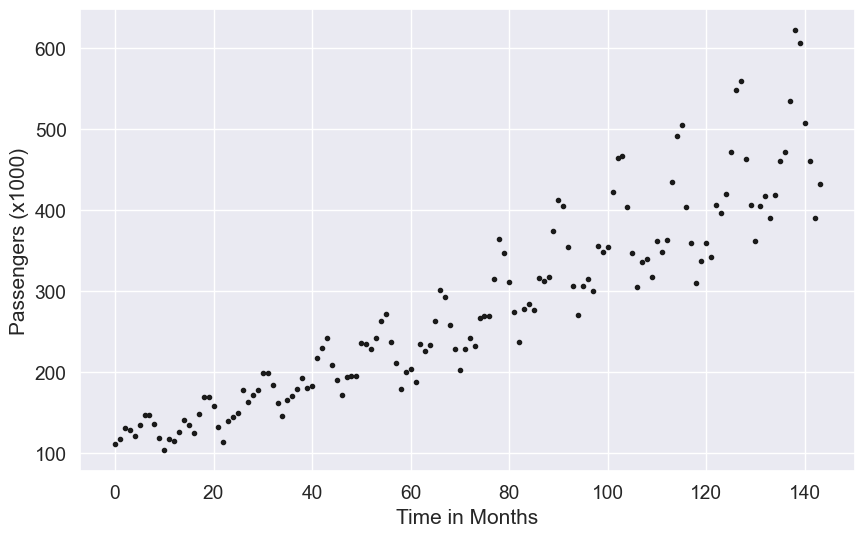

In [12]:
data = pd.read_csv('./AirPassengers.csv')
months = jnp.arange(0, len(data))[:, None]
passengers = jnp.array(data['#Passengers'].values)[:, None]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(months, passengers, 'k.')
ax.set_xlabel('Time in Months')
ax.set_ylabel('Passengers (x1000)');

Since the number of passengers is a strictly positive quantity, we can often get better results by modelling the logarithm of the number of passengers instead.  We also split the dataset into a training and test set

N      = 144
Ntrain = 110
Ntest  = 34


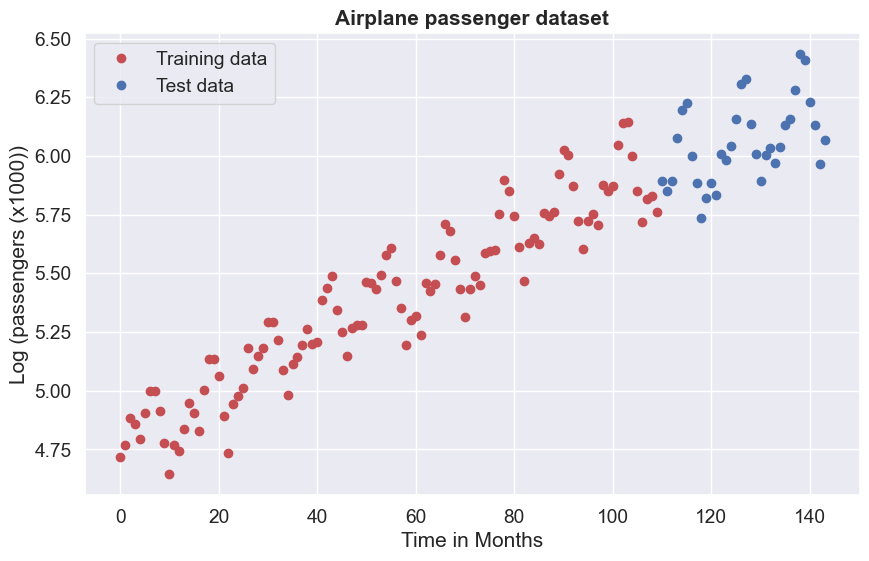

In [13]:
# log transform
y = jnp.log(passengers)

# split into  training and test
N = len(y)
Ntrain = 110
Ntest = N - Ntrain

x = jnp.arange(len(months))
xtrain = x[:Ntrain]
xtest = x[Ntrain:]

ytrain = y[:Ntrain]
ytest = y[Ntrain:]

print('N      = %d' % N)
print('Ntrain = %d' % Ntrain)
print('Ntest  = %d' % Ntest)


def plot_data(ax):
    ax.plot(xtrain, ytrain, 'ro', label='Training data')
    ax.plot(xtest, ytest, 'bo', label='Test data')
    ax.set_xlabel('Time in Months')
    ax.set_ylabel('Log (passengers (x1000))');
    ax.legend()
    ax.set_title('Airplane passenger dataset', fontweight='bold')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)
    



To measure the quality of the fit, we use the  **expected log predictive densities (ELPD)** for the training and test sets

\begin{align}
\text{ELPD} = \frac{1}{M}\sum_{i=1}^M \ln p(y^*_i|\mathbf{y}, \mathbf{x}^*_i),
\end{align}

where $p(y^*_i|\mathbf{y}, \mathbf{x}^*_i)$ is the posterior predictive distribution for observation $y^*_i$ in some dataset $\mathcal{D}_* = \left\lbrace \mathbf{x}^*_i, y^*_i \right\rbrace_{i=1}^M$. In contrast to simply reporting the mean square errors or similar, the ELPD also takes the uncertainty into account.

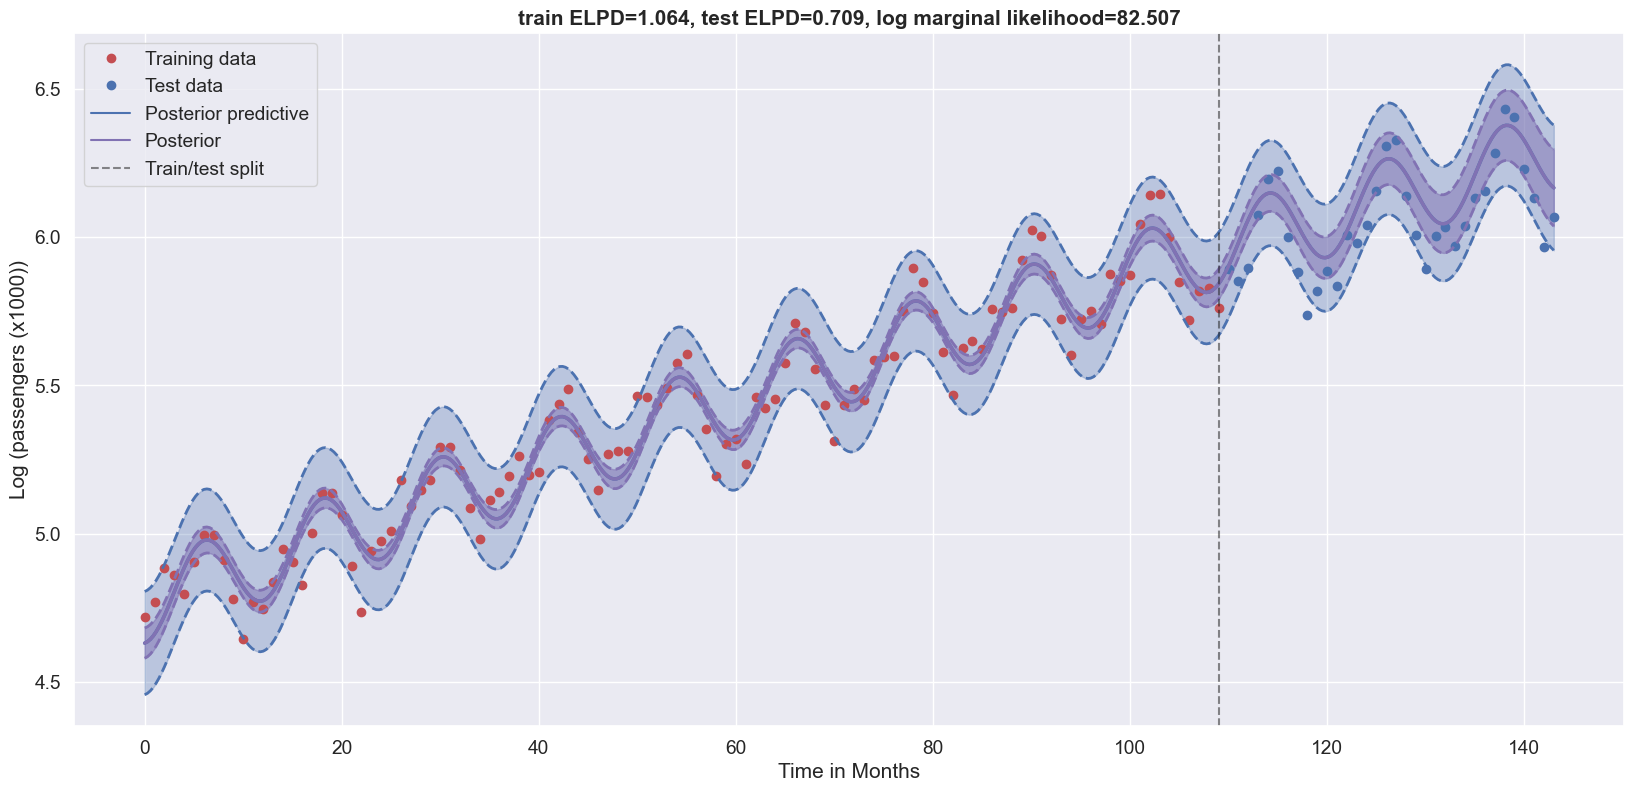

In [14]:
# we use the expected log predictive distribution as performance metric
def compute_elpd(y, mu, s2):
    """" y is a vector of observed values, and mu and s2 are the mean and variances of the posterior predictive distribution, respectively. """
    return jnp.mean(log_npdf(y.ravel(), mu.ravel(), s2.ravel()))

# Creates design matrix Phi based on input
def design_matrix(x):
    #return jnp.column_stack((jnp.ones(len(x)), x,   ))                                
    #return jnp.column_stack((jnp.ones(len(x)), x, x**2))
    return jnp.column_stack((jnp.ones(len(x)), x,   x**2, jnp.cos(2*jnp.pi*x/12)))       

# prepare input data
xpred = jnp.linspace(0, 143, 500)
Phi_train = design_matrix(xtrain)
Phi_test = design_matrix(xtest)
Phi_pred = design_matrix(xpred)

# fit model
model = BayesianLinearRegression(Phi_train, ytrain, alpha=1, beta=1)
model.optimize_hyperparameters() 
logZ = model.log_marginal_likelihood

# make predictions for plotting
ypred_mu, ypred_s2 = model.predict_f(Phi_pred)
tpred_mu, tpred_s2 = model.predict_y(Phi_pred)

# make predictions for training and test set & evaluate performance metrics
ytrain_mu, ytrain_s2 = model.predict_y(Phi_train)
ytest_mu, ytest_s2 = model.predict_y(Phi_test)
train_elpd = compute_elpd(ytrain, ytrain_mu, ytrain_s2)
test_elpd = compute_elpd(ytest, ytest_mu, ytest_s2)

# plot
fig, ax = plt.subplots(1, 1, figsize=(20,9))
plot_data(ax)
plot_predictions(ax, xpred, tpred_mu, tpred_s2, color='b', label='Posterior predictive', visibility=0.3)
plot_predictions(ax, xpred, ypred_mu, ypred_s2, color='m', label='Posterior')
ax.set_title('train ELPD=%4.3f, test ELPD=%4.3f, log marginal likelihood=%4.3f' % (train_elpd, test_elpd, logZ), fontweight='bold');
ax.axvline(xtrain[-1], color='k', linestyle='--', alpha=0.5, label='Train/test split')
ax.legend()


**Task 4.1**: Run the code with $\alpha = 10$ and $\beta = 1$ as initial values. Comment on the quality of the fit. Note the values of the negative log likelihood for the training and test set.



**Task 4.2**: Estimate $\alpha, \beta$ by optimizing the marginal likelihood by uncommenting the line, which calls the function *optimize_hyperparameters()*. Report the estimates for $\alpha$ and $\beta$.

**Solution**

In [15]:
print(f'Alpha: {model.alpha:4.3f}')
print(f'Beta:  {model.beta:4.3f} (sigma2 = {1./model.beta:4.3f})' )

Alpha: 0.176
Beta:  138.636 (sigma2 = 0.007)


**End of solution**

**Task 4.3**: Experiment with different linear models but the uncommenting different lines in the *design_matrix()* function. Comment on the train/test ELPDs as well as the marginal likelihood.


**Task 4.4**: Comment on uncertainty estimates for the training and test set.

**Task 4.5**: Compute and visualize the posterior and the posterior predictive distribution for the logarithm of the number of customers after 145 months?

**Solution**

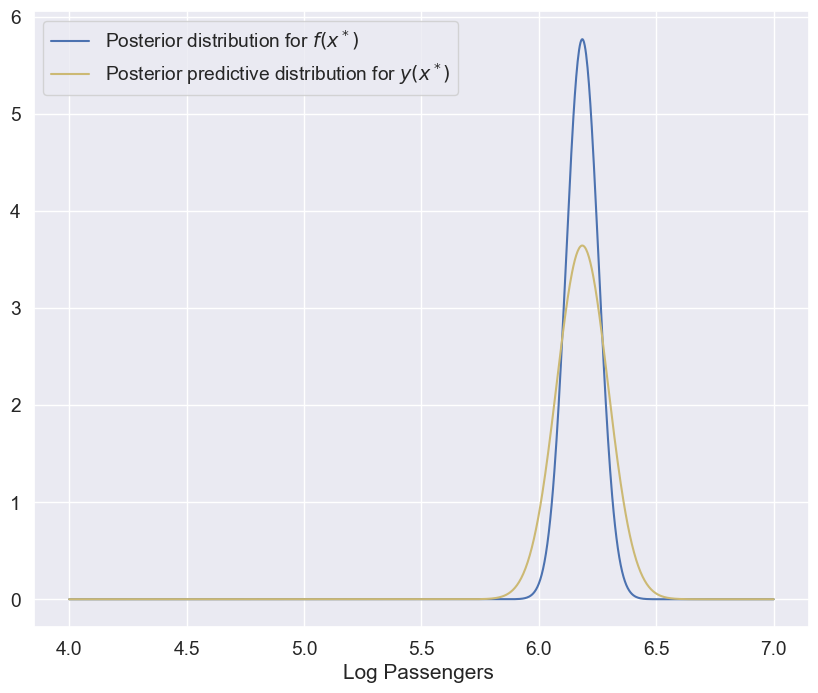

In [16]:
xstar = 145
Phi_star = design_matrix(jnp.array([xstar]))

fstar_mu, fstar_s2 = model.predict_f(Phi_star)
ystar_mu, ystar_s2 = model.predict_y(Phi_star)

fs = jnp.linspace(4, 7, 1000)
ys = jnp.linspace(4, 7, 1000)

npdf = lambda x, m, v: jnp.exp(-(x-m)**2/(2*v))/jnp.sqrt(2*jnp.pi*v)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ys, npdf(ys, fstar_mu, fstar_s2), label='Posterior distribution for $f(x^*)$', color='b')
ax.plot(ys, npdf(ys, ystar_mu, ystar_s2), label='Posterior predictive distribution for $y(x^*)$', color='y')
ax.legend(loc='upper left')
ax.set(xlabel='Log Passengers ');


**End of solution**

For statistical models like $y_n = f(\mathbf{x}_n) + e_n$, we typically refer to $e_n$ as noise, but another way to think about $e_n$ is that it represent the part of the signal we cannot explain by the model $f(\mathbf{x}_n)$. 

**Task 4.6**: If you get hired by an airline company, and they asked you to provide a 95% credibility interval for the number of log passengers after 145, would you use the posterior distribution $p(f_*|y, x_*)$ or the posterior predictive distribution $p(y_*|y, x_*)$? and why?

**Task 4.7**: Compute the predictive distribution for the number of passengers instead of the logarithm of the number of passengers. 

- Hints: You can either using sampling techniques or you use the fact that exponentiating a Gaussian random variable is a Log-Normal distribution with closed-form moments. See more here: [https://en.wikipedia.org/wiki/Log-normal_distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)

**Solution**

Let $y(x)$ denote the logarithm  of the number of passengers after x months and let $y(x)|\mathbf{t} \sim N(m, v)$ denote the predictive distribution for $y(x)$, then the number of passengers $P(x)$ is then given by 

$$\begin{align}
P(x) = \exp[y(x)]
\end{align}$$

Now because $\log P(x) \sim N(m, v)$, $P(x)$ is said to follow a log-normal distribution (https://en.wikipedia.org/wiki/Log-normal_distribution). 

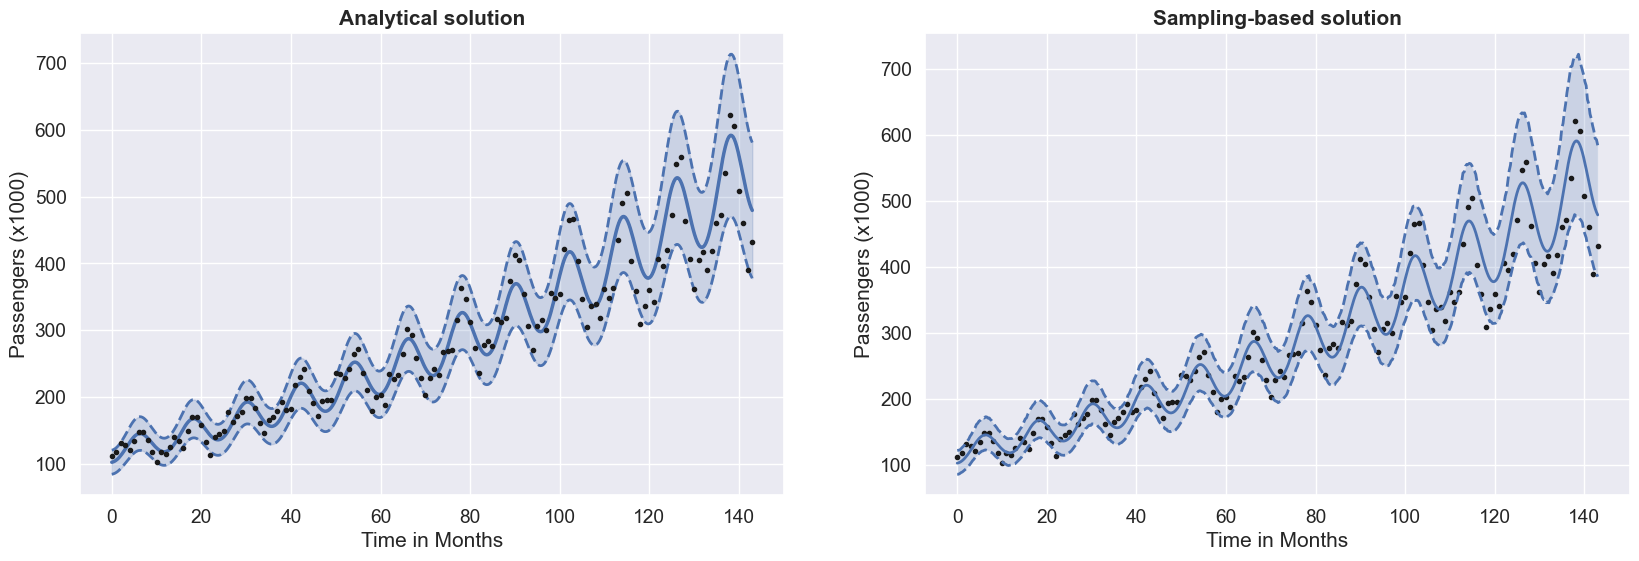

In [17]:
# prepare data and predict mean and variance for t(x)
ypred_mu, ypred_s2 = model.predict_y(Phi_pred)

################################################
# Analytical solution via log-normal 
################################################
# compute mean and variance of exp(t(x))
lognormal_mean = lambda m, v: jnp.exp(m + 0.5*v)
lognormal_var = lambda m, v: (jnp.exp(v) - 1)*jnp.exp(2*m + v)
exp_y_mu = lognormal_mean(ypred_mu.ravel(), ypred_s2.ravel()) 
exp_y_s2 = lognormal_var(ypred_mu.ravel(), ypred_s2.ravel()) 


################################################
# Sampling-based solution
################################################

# generate samples from posterior predictive distribution for y
num_samples = 5000
key = random.PRNGKey(1)
y_samples = ypred_mu + jnp.sqrt(ypred_s2)*random.normal(key, shape=(num_samples, len(ypred_mu)))

# transform all samples by exponentialing
exp_y_samples = jnp.exp(y_samples)

# estimatepercentiles
lower = jnp.percentile(exp_y_samples, 2.5, axis=0)
upper = jnp.percentile(exp_y_samples, 97.5, axis=0)



# plot analytical solution
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_predictions(ax[0], xpred, exp_y_mu, exp_y_s2, color='b', visibility=0.2)
ax[0].plot(months, passengers, 'k.')
ax[0].set_xlabel('Time in Months')
ax[0].set_ylabel('Passengers (x1000)')
ax[0].set_title('Analytical solution', fontweight='bold')


# plot sampling-based solution
ax[1].plot(months, passengers, 'k.')
ax[1].fill_between(xpred, lower, upper, alpha=0.2)
ax[1].plot(xpred, exp_y_mu, 'b-', linewidth=2)
ax[1].plot(xpred, lower, 'b--', xpred, upper, 'b--', linewidth=2)
ax[1].set_xlabel('Time in Months')
ax[1].set_ylabel('Passengers (x1000)')
ax[1].set_title('Sampling-based solution', fontweight='bold');


**End of solution**